# Noise Removal With Neural Network

Author: Amir Fawwaz

Affliation: HT Consulting (Asia) Sdn. Bhd., Kelana Jaya, Malaysia

Published: 27 June 2022

# Introduction

<p style='text-align: justify;'>

Deep learning, a subfield of machine learning (ML), has seen a dramatic resurgence in the recent years, largely driven by increases in computational power via availibilty of [NVIDIA's GPU](https://www.nvidia.com/en-us/high-performance-computing/hpc-and-ai/) and the availability of massive new datasets.  Historically, constructing a ML system required domain expertise and human engineering to design feature extractors that transformed raw data into suitable representations from which a learning algorithm could detect patterns. In contrast, deep learning is a form of representation learning in which a machine is fed with raw data and develops its own representations needed for pattern recognition that is composed of multiple layers of representations. These layers are typically arranged sequentially and composed of a large number of primitive, nonlinear operations, such that the representation of one layer (beginning with the raw data input) is fed into the next layer and transformed into a more abstract representation1. As data flows through the layers of the system, the input space becomes iteratively warped until data points become distinguishable (Fig. 1a). In this manner, highly complex functions can be learned.

</p>

## Problem Statement

In this note, we aim to solve classification using standard convolution neural network (CNN).

## Experiments 
### Hardware setup

This experiment was conducted on a workstation with the following specification:

- Windows 11 Pro Home
- Intel i7-13700KF, 3.4Ghz
- 16GB DDR4, 3200MHz
- 1TB HDD NVMe
- python 3.10.11 (64-bit)
- CUDA 11.8
- cuDNN 8.6

### Datasets

Experiments are performed on dataset from [kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

In [2]:
# Import libraries

import os
import numpy as np
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Set seed for experiment reproducibility
seed=1234
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
data_path = "brain_tumor"

labels = ['glioma','meningioma','notumor','pituitary']

In [4]:
%%time
# prepare the training data

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join(data_path,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(data_path,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 445.26it/s]


CPU times: total: 2.69 s
Wall time: 13.5 s


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(7023, 150, 150, 3)

Split dataset to 90%-10% ratio

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Now, let's define the model

In [8]:
def model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(image_size,image_size,3)))
    model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
    model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
    model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
    model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
    model.add(keras.layers.Conv2D(256,(3,3),activation='relu'))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512,activation = 'relu'))
    model.add(keras.layers.Dense(512,activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(4,activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    return model

### Model Topology

CNN topology used in this training, can be observed below.

In [9]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

Now, let's train our model

In [11]:
%%time
history = model.fit(X_train,y_train,epochs=30,validation_split=0.1, batch_size=32, verbose=2)

Epoch 1/30
178/178 - 24s - loss: 1.4749 - accuracy: 0.4372 - val_loss: 1.4802 - val_accuracy: 0.3560 - 24s/epoch - 135ms/step
Epoch 2/30
178/178 - 12s - loss: 0.7921 - accuracy: 0.6742 - val_loss: 1.1856 - val_accuracy: 0.5285 - 12s/epoch - 67ms/step
Epoch 3/30
178/178 - 12s - loss: 0.6429 - accuracy: 0.7412 - val_loss: 1.5243 - val_accuracy: 0.3481 - 12s/epoch - 67ms/step
Epoch 4/30
178/178 - 12s - loss: 0.5488 - accuracy: 0.7744 - val_loss: 0.5871 - val_accuracy: 0.7611 - 12s/epoch - 67ms/step
Epoch 5/30
178/178 - 12s - loss: 0.4702 - accuracy: 0.8145 - val_loss: 0.9208 - val_accuracy: 0.6535 - 12s/epoch - 67ms/step
Epoch 6/30
178/178 - 12s - loss: 0.3804 - accuracy: 0.8550 - val_loss: 0.5610 - val_accuracy: 0.7658 - 12s/epoch - 68ms/step
Epoch 7/30
178/178 - 12s - loss: 0.3322 - accuracy: 0.8710 - val_loss: 0.5315 - val_accuracy: 0.7927 - 12s/epoch - 68ms/step
Epoch 8/30
178/178 - 12s - loss: 0.2928 - accuracy: 0.8873 - val_loss: 0.4628 - val_accuracy: 0.8085 - 12s/epoch - 67ms/step

### Network Training

The models are trained using standard tensorflow on a single _Nvidia RTX 3060_ took almost 6 minutes to converge. When observed, training was cap at 30 epoch to avoid overfitting and can be seen from plots below. We train using a fixed seed for reproducibility.

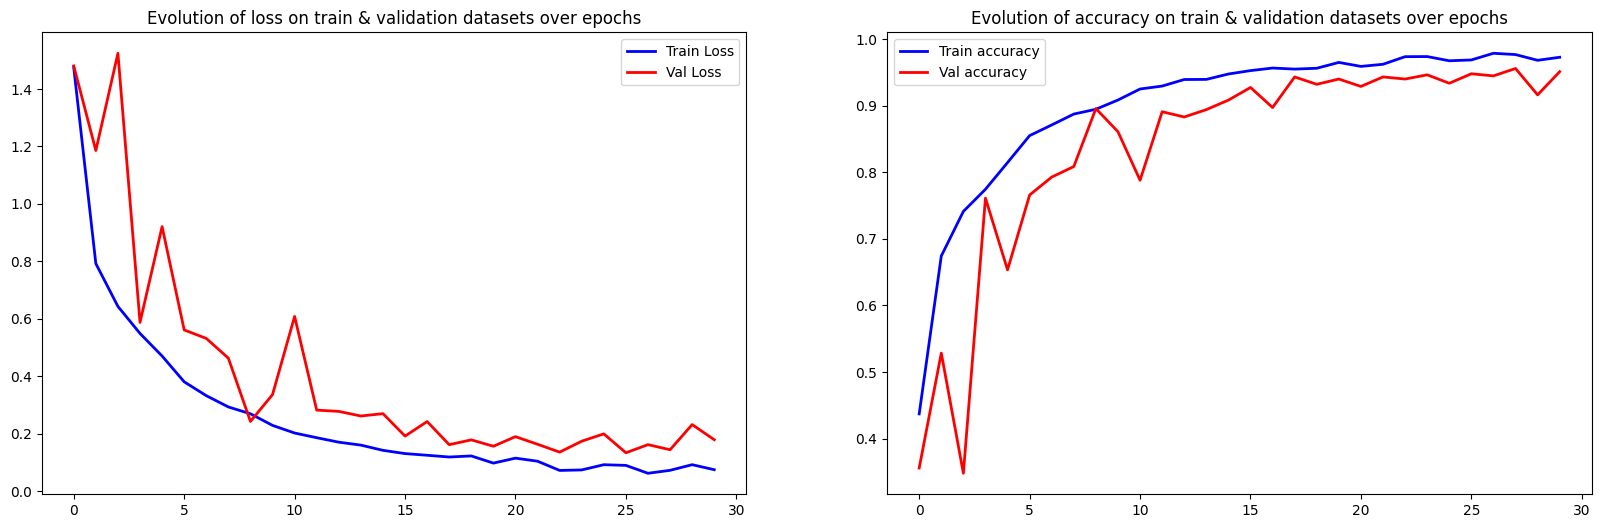

In [12]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_acc = history.history['accuracy']
epoch_val_acc = history.history['val_accuracy']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2,label='Val accuracy')
plt.title('Evolution of accuracy on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

Plot above show training loss & accuracy training plot. We can observed that accuracy is improving near 0.9 for both train & validation dataset. Also can be observed is loss value is approaching 0 for both both train & validation dataset.  

In [13]:
# save model and architecture to single file
model.save("brain_tumor_150wh.h5")

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.28870490193367004
Test accuracy: 0.9246088266372681


Overall, classification accuracy achieve 92.4% with low loss.

In [15]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

22/22 [==============================] - 1s 25ms/step


Evaluation

In this,
0 - Glioma Tumor
1 - No Tumor
2 - Meningioma Tumor
3 - Pituitary Tumor

In [16]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       170
           1       0.85      0.90      0.87       175
           2       0.99      0.96      0.97       202
           3       0.95      0.97      0.96       156

    accuracy                           0.92       703
   macro avg       0.92      0.92      0.92       703
weighted avg       0.93      0.92      0.92       703



### Metrics & Results

For the evaluation we use `scikit-learn` classification report.

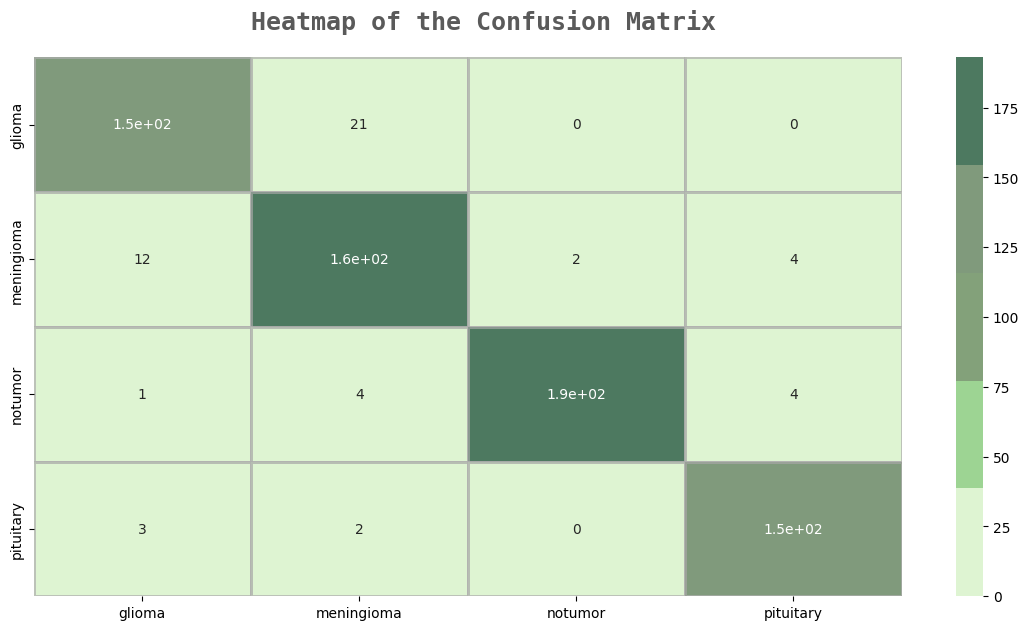

In [17]:
import seaborn as sns

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

# sns.palplot(colors_dark)
# sns.palplot(colors_green)
# sns.palplot(colors_red)

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## Reference

1. [Brain Tumor MRI Classification with Tensorflow](https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn)